In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat
from scipy.io import loadmat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())



cuda:0


In [2]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     x = xt[:,0].reshape(-1,1)
#     t = xt[:,1].reshape(-1,1)
#     y = x*np.cos(5*np.pi*t) + np.power(x*t,3)
#     return y.reshape(-1,1)    

In [3]:
pi = np.pi
Re = 1000
level = "high"
label = "NS_stan_" + level

t_max = 

x = np.linspace(0,1,101).reshape(-1,1)
y = np.linspace(0,1,101).reshape(-1,1)
t = np.linspace(0,50,101).reshape(-1,1)

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

# y_true = true_2D_1(xt)
# y_true_norm = np.linalg.norm(y_true,2)

#bound_pts_idx = ((X == -5) + (X == 5) + (T == 0)).reshape(-1,)

#xt_bound = xt[bound_pts_idx,:]
#y_bound = y_true[bound_pts_idx,:]


xyt_test_tensor = torch.from_numpy(xyt).float().to(device)


lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [4]:
def trainingdata(N_I,N_B,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    x_I = np.random.uniform(size = N_I).reshape(-1,1)
    y_I = np.random.uniform(size = N_I).reshape(-1,1)
    t_I = np.zeros((N_I,1))
    xyt_I = np.hstack((x_I,y_I,t_I))
    u_I = np.zeros((N_I,1))
    v_I = np.zeros((N_I,1))
    p_I = np.zeros((N_I,1))
    
    #Top
    x_BC1 = np.random.uniform(size = N_B).reshape(-1,1)
    y_BC1 = np.ones((N_B,1))
    t_BC1 = np.random.uniform(size = N_B).reshape(-1,1)
    xyt_BC1 = np.hstack((x_BC1,y_BC1,t_BC1))
    u_BC1 = np.ones((N_B,1))
    v_BC1 = np.zeros((N_B,1))
    
    #Right
    x_BC2 = np.ones((N_B,1))
    y_BC2 = np.random.uniform(size = N_B).reshape(-1,1)
    t_BC2 = np.random.uniform(size = N_B).reshape(-1,1)
    xyt_BC2 = np.hstack((x_BC2,y_BC2,t_BC2))
    u_BC2 = np.zeros((N_B,1))
    v_BC2 = np.zeros((N_B,1))

    #Bottom
    x_BC3 = np.random.uniform(size = N_B).reshape(-1,1)
    y_BC3 = np.zeros((N_B,1))
    t_BC3 = np.random.uniform(size = N_B).reshape(-1,1)
    xyt_BC3 = np.hstack((x_BC3,y_BC3,t_BC3))
    u_BC3 = np.zeros((N_B,1))
    v_BC3 = np.zeros((N_B,1))
    
    #Left
    x_BC4 = np.zeros((N_B,1))
    y_BC4 = np.random.uniform(size = N_B).reshape(-1,1)
    t_BC4 = np.random.uniform(size = N_B).reshape(-1,1)
    xyt_BC4 = np.hstack((x_BC4,y_BC4,t_BC4))
    u_BC4 = np.zeros((N_B,1))
    v_BC4 = np.zeros((N_B,1))
    
    
    xyt_BC = np.vstack((xyt_BC1,xyt_BC2,xyt_BC3,xyt_BC4))
    u_BC = np.vstack((u_BC1,u_BC2,u_BC3,u_BC4))
    v_BC = np.vstack((v_BC1,v_BC2,v_BC3,v_BC4))

    x_p = np.zeros((N_B,1))
    y_p = np.zeros((N_B,1))
    t_p = np.random.uniform(size = N_B).reshape(-1,1)
    xyt_p = np.hstack((x_p,y_p,t_p))
    u_p = np.zeros((N_B,1))
    v_p = np.zeros((N_B,1))
    p_p = np.zeros((N_B,1))
    
    xyt_Ip = np.vstack((xyt_I,xyt_p))
    u_Ip = np.vstack((u_I,u_p))
    v_Ip = np.vstack((v_I,v_p))
    p_Ip = np.vstack((p_I,p_p))

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    
    xyt_coll = np.vstack((xyt_coll, xyt_BC,xyt_I,xyt_p)) # append training points to collocation points 

    return xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        
        beta_mean = 1.0*torch.ones((50,len(layers)-2))
        beta_std = 0.01*torch.ones((50,len(layers)-2))
        
        self.beta = Parameter(torch.normal(beta_mean,beta_std))
        self.beta.requiresGrad = True

            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = 2.0*(xyt - lbxyt)/(ubxyt - lbxyt) - 1.0
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z)
            a = z1 + self.beta[:,i]*z*z1            
        
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xyt_BC,u_BC,v_BC):
                
        uvp = self.forward(xyt_BC)
        
        loss_bc_u = self.loss_function(uvp[:,0:1],u_BC)
        loss_bc_v = self.loss_function(uvp[:,1:2],v_BC)
        
        # psi_p_pred = self.forward(torch.cat((x1,y1,t1),dim =1))
        # psi = psi_p_pred[:,0:1]
        # p_pred = psi_p_pred[:,1:2]
                
        return loss_bc_u + loss_bc_v
    
    def loss_Ip(self,xyt_Ip,u_Ip,v_Ip,p_Ip):
                
        uvp = self.forward(xyt_Ip)
        
        loss_ip_u = self.loss_function(uvp[:,0:1],u_Ip)
        loss_ip_v = self.loss_function(uvp[:,1:2],v_Ip)
        loss_ip_p = self.loss_function(uvp[:,2:3],p_Ip)
        
        # psi_p_pred = self.forward(torch.cat((x1,y1,t1),dim =1))
        # psi = psi_p_pred[:,0:1]
        # p_pred = psi_p_pred[:,1:2]
                
        return loss_ip_u + loss_ip_v+loss_ip_p
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        uvp = self.forward(g) 
        
        u = uvp[:,0:1]
        v = uvp[:,1:2]
        p = uvp[:,2:3]
        
        
        #u
        u_xyt = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
    
        u_xx_yy_tt = autograd.grad(u_xyt,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dx = u_xyt[:,[0]]
        du_dy = u_xyt[:,[1]]
        du_dt = u_xyt[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]
        
        #v
        v_xyt = autograd.grad(v,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        v_xx_yy_tt = autograd.grad(v_xyt,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dv_dx = v_xyt[:,[0]]
        dv_dy = v_xyt[:,[1]]
        dv_dt = v_xyt[:,[2]]
        
        d2v_dx2 = v_xx_yy_tt[:,[0]]
        d2v_dy2 = v_xx_yy_tt[:,[1]]
        
        #p
        p_xyt = autograd.grad(p,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]

        dp_dx = p_xyt[:,[0]]
        dp_dy = p_xyt[:,[1]]
    
        
        
        f_u = du_dt + u*du_dx + v*du_dy + dp_dx - (d2u_dx2 + d2u_dy2)/Re
        f_v = dv_dt + u*dv_dx + v*dv_dy + dp_dy - (d2v_dx2 + d2v_dy2)/Re
        
        
        loss_f_u = self.loss_function(f_u,f_hat)
        loss_f_v = self.loss_function(f_v,f_hat)
                
        return loss_f_u + loss_f_v
    
    
    def loss_NBC(self,xyt_coll,N_hat):
        g = xyt_coll.clone()             
        g.requires_grad = True
        uvp = self.forward(g)
        
        u = uvp[:,0:1]
        v = uvp[:,1:2]
        
        u_xyt = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        v_xyt = autograd.grad(v,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du_dx = u_xyt[:,[0]]
        dv_dy = v_xyt[:,[1]]
        
        loss_nbc = self.loss_function(du_dx + dv_dy, N_hat)
                
        return loss_nbc
    
    
    def loss(self,xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip,f_hat,N_hat):

        loss_BC = self.loss_BC(xyt_BC,u_BC,v_BC)
        loss_Ip = self.loss_Ip(xyt_Ip,u_Ip,v_Ip,p_Ip)
        loss_NBC = self.loss_NBC(xyt_coll,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_BC + loss_f + loss_NBC +loss_Ip
        
        return loss_val
         
    'test neural network'
    def test(self):
        y_pred = self.forward(xt_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()
   
        return y_pred
    
    def test_loss(self):
        # y_pred = self.test()
        
        # test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        # test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        test_mse = 0
        test_re = 0
        
        return test_mse, test_re  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step(xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip,f_hat,N_hat,seed):
    
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip,f_hat,N_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [8]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip = trainingdata(N_I,N_B,N_f,rep*11)
    xyt_coll = torch.from_numpy(xyt_coll).float().to(device)
    xyt_BC = torch.from_numpy(xyt_BC).float().to(device)
    u_BC = torch.from_numpy(u_BC).float().to(device)
    v_BC = torch.from_numpy(v_BC).float().to(device)
    
    xyt_Ip = torch.from_numpy(xyt_Ip).float().to(device)
    u_Ip = torch.from_numpy(u_Ip).float().to(device)
    v_Ip = torch.from_numpy(v_Ip).float().to(device)
    p_Ip = torch.from_numpy(p_Ip).float().to(device)
    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)
    N_hat = torch.zeros(xyt_coll.shape[0],1).to(device)
    
    loss_np = PINN.loss(xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip,f_hat,N_hat).cpu().detach().numpy()
    data_update(loss_np)
    for i in range(max_iter):
        if(np.isnan(loss_np) == False):
            train_step(xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip,f_hat,N_hat,i)
            loss_np = PINN.loss(xyt_coll, xyt_BC,u_BC,v_BC, xyt_Ip, u_Ip,v_Ip, p_Ip,f_hat,N_hat).cpu().detach().numpy()
        

        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
      

    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 1 #10
max_iter = 500 #200

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 0

N_I = 2000  #Total number of data points for 'y'
N_B = 2000
N_f = 10000 #Total number of collocation points

for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []

    torch.manual_seed(reps*36)

    layers = np.array([3,50,50,50,50,3]) #9 hidden layers
    # layers = np.array([2,50,50,50,50,50,50,50,1])

    PINN = Sequentialmodel(layers,beta_init)

    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                            max_iter = 20, 
                            max_eval = 30, 
                            tolerance_grad = 1e-8, 
                            tolerance_change = 1e-8, 
                            history_size = 100, 
                            line_search_fn = 'strong_wolfe')




    nan_flag = train_model(max_iter,reps)



    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time
    beta_full.append(beta_val)


  #print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

NS_stan_high
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)
0
0 Train Loss 0.08087251 Test MSE 0 Test RE 0
1 Train Loss 0.04431518 Test MSE 0 Test RE 0
2 Train Loss 0.027630595 Test MSE 0 Test RE 0
3 Train Loss 0.019547788 Test MSE 0 Test RE 0
4 Train Loss 0.014754048 Test MSE 0 Test RE 0
5 Train Loss 0.012509428 Test MSE 0 Test RE 0


KeyboardInterrupt: 

In [ ]:
nan_flag = train_model(max_iter,reps)

In [10]:
uvp_pred = PINN.forward(xyt_test_tensor).cpu().detach().numpy()

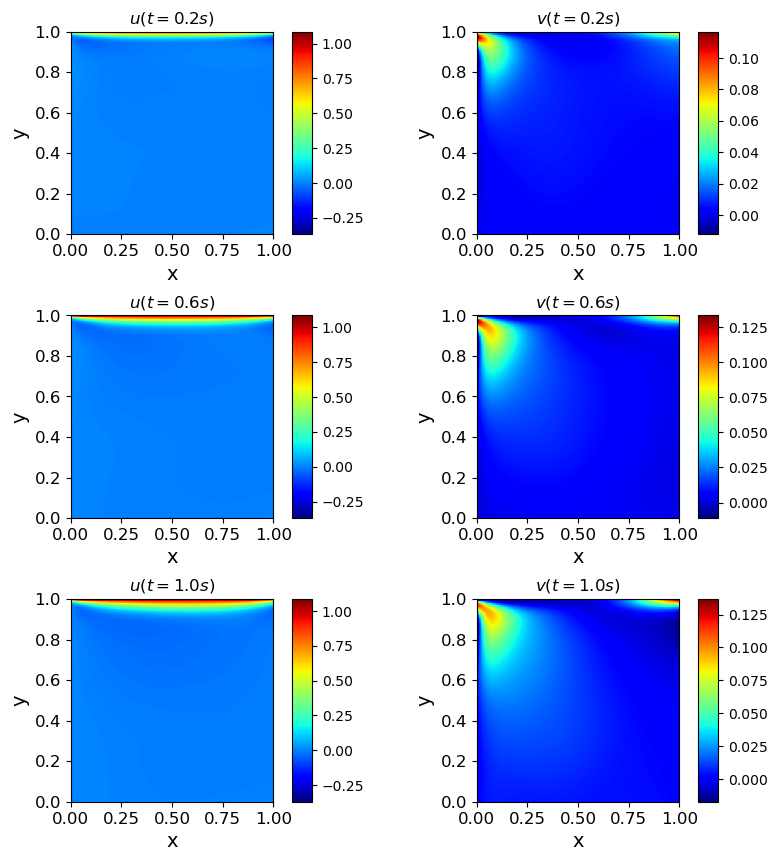

In [11]:
u_pred = uvp_pred[:,0].reshape(101,101,101)
v_pred = uvp_pred[:,1].reshape(101,101,101)

a = 10
b = 10
fig,axs = plt.subplots(3,2)

frame_idx = 19

ax = axs[0,0]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(u_pred[frame_idx,:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1],vmin = np.min(u_pred),vmax = np.max(u_pred))
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$u (t=0.2s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])


#-------------------------------------------------------------------

ax = axs[0,1]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(v_pred[frame_idx,:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1])
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$v (t=0.2s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

#--------------------------------------------------------------------------------------------------------
frame_idx = 59

ax = axs[1,0]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(u_pred[frame_idx,:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1],vmin = np.min(u_pred),vmax = np.max(u_pred))
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$u (t=0.6s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])


#-------------------------------------------------------------------

ax = axs[1,1]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(v_pred[frame_idx,:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1])
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$v (t=0.6s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

fig.subplots_adjust(wspace = 0.7)


#--------------------------------------------------------------------------------------------------------
frame_idx = 99

ax = axs[2,0]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(u_pred[frame_idx,:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1],vmin = np.min(u_pred),vmax = np.max(u_pred))
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$u (t=1.0s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])


#-------------------------------------------------------------------

ax = axs[2,1]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(v_pred[frame_idx,:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1])
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$v (t=1.0s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

fig.subplots_adjust(wspace = 0.1,hspace = 0.4)
# plt.savefig('NS_lid.svg', format='svg',pad_inches=0, bbox_inches='tight',transparent=True)

(0.0, 1.0)

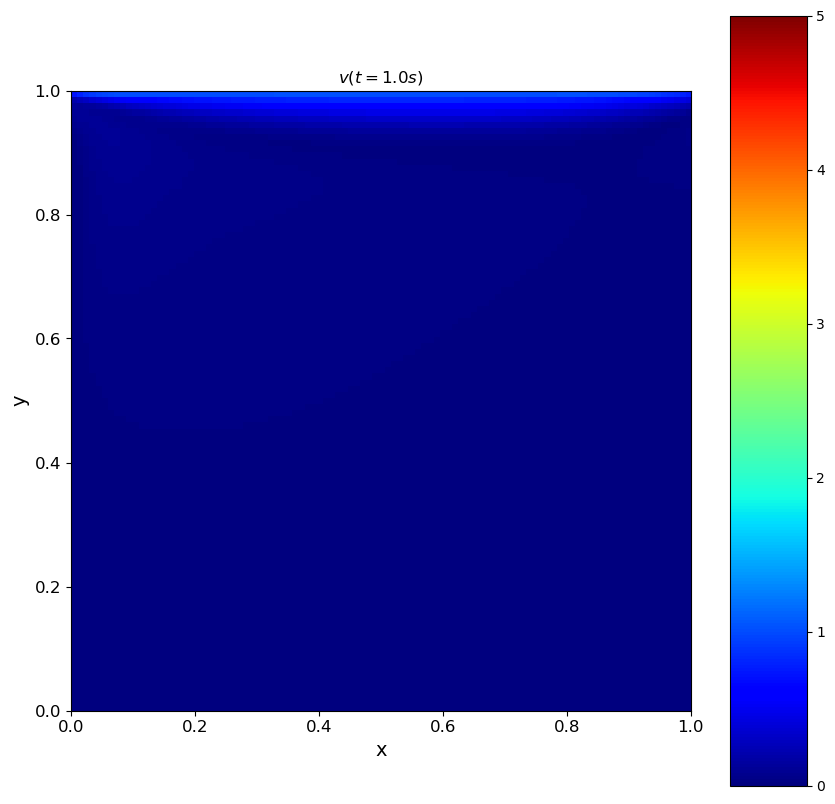

In [12]:
fig, ax = plt.subplots()
frame_idx = 99
ax.figure.set_size_inches(a,b)
psi = np.sqrt(np.square(v_pred[frame_idx,:,:]) + np.square(u_pred[frame_idx,:,:])) 
img = ax.imshow(np.flip(np.transpose(psi),axis =0),cmap = 'jet',extent= [0,1,0,1],vmax = 5,vmin = 0)
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$v (t=1.0s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

# plt.savefig('NS_lid.svg', format='svg',pad_inches=0, bbox_inches='tight',transparent=True)

In [14]:
u_matlab = loadmat("uv_matlab.mat")['u']
v_matlab = loadmat("uv_matlab.mat")['v']

frame_idx = 100
fig,axs = plt.subplots(1,2)
a = 10
b = 3

fig.set_size_inches(a,b)

ax = axs[0]
ax.plot(y,u_matlab[50,:],'b-.',label = 'SOR')
ax.plot(y,u_pred[frame_idx,50,:],'r',label = 'PINN')
ax.set_xlim([0,1])
ax.legend()
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x=0.5)$')
ax.set_title('Velocity in $x$-direction') 

ax = axs[1]
ax.plot(x,v_matlab[:,50],'b-.',label = 'SOR')
ax.plot(x,v_pred[frame_idx,:,50],'r',label = 'PINN')
ax.set_xlim([0,1])
ax.legend(loc = 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$v(y=0.5)$')
ax.set_title('Velocity in $y$-direction') 

fig.subplots_adjust(wspace = 0.4)
# plt.savefig('SOR_PINN.svg', format='svg',bbox_inches = 'tight')

FileNotFoundError: [Errno 2] No such file or directory: 'uv_matlab.mat'

In [13]:
u_pred = u_matlab
v_pred = v_matlab

a = 10
b = 10
fig,axs = plt.subplots(1,2)

frame_idx = 99

ax = axs[0]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(u_pred[:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1],vmin = np.min(u_pred),vmax = np.max(u_pred))
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10,fraction=0.08)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$u (t=1.0s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])


#-------------------------------------------------------------------

ax = axs[1]
ax.figure.set_size_inches(a,b)
img = ax.imshow(np.flip(np.transpose(v_pred[:,:]),axis =0),cmap = 'jet',extent= [0,1,0,1])
# fig.colorbar(img)
cbar = fig.colorbar(img, ax=ax,aspect = 10,fraction=0.08)

ax.set_xlabel('x',fontsize = 14)
ax.set_ylabel('y',fontsize = 14)

ax.set_title("$v (t=1.0s)$",fontsize = 12)
ax.tick_params(axis = 'x',labelsize = 12)
ax.tick_params(axis = 'y',labelsize = 12)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

fig.subplots_adjust(wspace = 0.3)

# plt.savefig('NS_lid_SOR.svg', format='svg',pad_inches=0, bbox_inches='tight',transparent=True)

NameError: name 'u_matlab' is not defined

In [ ]:
X, Y = np.meshgrid(np.linspace(0, 1, 101), np.linspace(0, 1, 101))
u = u_pred[frame_idx,:,:]  # Replace with your u values
v = v_pred[frame_idx,:,:]  # Replace with your v values
xstart =np.random.uniform()
ystart = np.random.uniform()  # Replace with your starting points
L = 1  # Replace with the desired value for L

# Create the streamline plot
# fig = plt.figure(3)
h = plt.streamplot(X, Y, u.T, v.T, start_points=np.column_stack([xstart, ystart]), color='k',linewidth=1.5, density=0.1, arrowstyle='->', arrowsize=1.5)
plt.title('Stream Function')
plt.xlabel('x-location')
plt.ylabel('y-location')
# plt.axis('equal', [0,1, 0, 1])

plt.show()

In [ ]:
p_pred = uvp_pred[:,2].reshape(100,100,100)
fig,ax = plt.subplots()
img = ax.imshow(np.flip(np.transpose(p_pred[99,:,:]),axis =0),cmap = 'jet')
fig.colorbar(img)